In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [62]:
def grid_search_to_df(grid_search_path, n_features_info_path):
    # Contains a list of grid analysis entries and their corresponding RMSEs
    # The grid analysis done on the matrix completion model tested permutations of the hyperparameters available in the mode
    # such as feature number, number of total trees to train, and the number of best trees to use for prediction
    grid_search_df = pd.read_csv(grid_search_path).set_index("full_comparison_name").drop(["Unnamed: 0"], axis=1)
    # n_features_info_df contains information on the number of overlapping viruses between each comparison (source and target table pair tested in grid analysis) 
    n_features_info_df = pd.read_csv(n_features_info_path).set_index('Unnamed: 0')
    comparisons = []
    for i in n_features_info_df.n_features_info:
        _, source, _, target, _, _, _, _, _ = i.split(' ') # Extract relevant information (source and target table names from entry)
        comparison_name = f"{source[:-1]}_to_{target[:-1]}" # Create a name for the comparison which can be used for identifying subsets of grid_search_df
        comparisons.append(comparison_name)
    # grid_per_comparison is a dict containing all the grid search entries corresponding to a comparison (entries will be permutations of hyperparameter settings)
    grid_per_comparison = {comparison: [i for i in grid_search_df.index if comparison in i] for comparison in comparisons}

    # The following code creates a dataframe that can be used to plot the grid analysis for each comparison
    grid_heatmap_per_comparison = dict()
    for comparison in comparisons:
        grid_indices = grid_per_comparison[comparison]
        grid_heatmap_df = pd.DataFrame() # Heatmap of grid analysis results for a comparison (source and target table pair)
        for idx in grid_indices: # Iterate over each entry name from the grid search dataframe
            if "fon" in idx or "hin" in idx:
                source, _, target_p1, target_p2, _, _, n_features, _, _, train_trees, _, _, best_trees = idx.split('_') 
            else:
                source, _, target, _, _, n_features, _, _, train_trees, _, _, best_trees = idx.split('_') # Extract relevant fields from entry name
            RMSE = grid_search_df.loc[idx, 'RMSE'] # Access the recorded RMSE of the grid analysis entry
            grid_heatmap_df.loc[f'n_features_{n_features}',f'train_trees_{train_trees}_best_trees_{best_trees}'] = RMSE # Save the grid search information to a dataframe that can be plotted as a heatmap
        grid_heatmap_per_comparison[comparison] = grid_heatmap_df
    return grid_heatmap_per_comparison, grid_search_df, n_features_info_df


def plot_grid_search(grid_heatmap_per_comparison, n_features_info_df, fs_x=12, fs_y=12, exclude_targets = list()):
#     comparisons = [f"{i.split(' ')[1][:-1]}_to_{i.split(' ')[3][:-1]}" for i in n_features_info_df.n_features_info]
    comparisons = list(grid_heatmap_per_comparison.keys())
    source_tables = set([i.split('_')[0] for i in comparisons])
    comparisons_per_source_table = {source_table: list() for source_table in source_tables}
    for comparison in comparisons:
        source_table = comparison.split("_")[0]
        comparisons_per_source_table[source_table].append(comparison)
        
    for source_table in comparisons_per_source_table: 
        curr_comparisons = comparisons_per_source_table[source_table] # Comparisons specific to one source table
        print(curr_comparisons)
        curr_comparisons = [i for i in curr_comparisons if i.split("_to_")[-1] not in exclude_targets]
        nrows = len(curr_comparisons)
        fig, axs = plt.subplots(nrows=nrows, ncols=1, figsize=(fs_x, fs_y))
        
        for idx, comparison in enumerate(curr_comparisons):
            sns.heatmap(grid_heatmap_per_comparison[comparison], ax=axs[idx])
            target_table = comparison.split("_to_")[-1]
            axs[idx].set_ylabel(target_table)
        
        for i in range(len(curr_comparisons)-1): # Removes x-labels for all except last row
            axs[i].set_xticklabels("")


        fig.suptitle(f"{source_table} Grid Analysis")
        fig.supxlabel("Total Trees Trained and Number of Best Trees Used")
        fig.supylabel("Number of features used")
        plt.tight_layout()
        plt.show()
    return

In [3]:
df = pd.read_csv('n_features_info.csv')
df['Source Table'] = [i.split(" ")[1][:-1] for i in df.n_features_info]
df['Target Table'] = [i.split(" ")[3][:-1] for i in df.n_features_info]
df['Overlapping Virus Count'] = [int(i.split(" ")[-1]) for i in df.n_features_info]
df = df.drop(['Unnamed: 0', 'n_features_info', 'Source Table'], axis=1).set_index("Target Table")

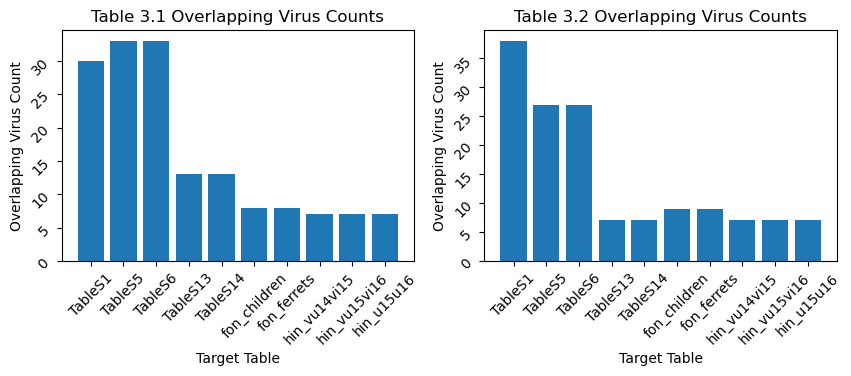

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,3))

axs[0].set_title("Table 3.1 Overlapping Virus Counts")
axs[0].set_xlabel("Target Table")
axs[0].set_ylabel("Overlapping Virus Count")
axs[0].bar(df.index[10:], df['Overlapping Virus Count'][10:])
axs[0].tick_params(labelrotation=45)

axs[1].set_title("Table 3.2 Overlapping Virus Counts")
axs[1].set_xlabel("Target Table")
axs[1].set_ylabel("Overlapping Virus Count")
axs[1].bar(df.index[:10], df['Overlapping Virus Count'][:10])
axs[1].tick_params(labelrotation=45)


['TableS3.1_to_TableS1', 'TableS3.1_to_TableS5', 'TableS3.1_to_TableS6', 'TableS3.1_to_TableS13', 'TableS3.1_to_TableS14', 'TableS3.1_to_fon_children', 'TableS3.1_to_fon_ferrets', 'TableS3.1_to_hin_vu14vi15', 'TableS3.1_to_hin_vu15vi16', 'TableS3.1_to_hin_u15u16']


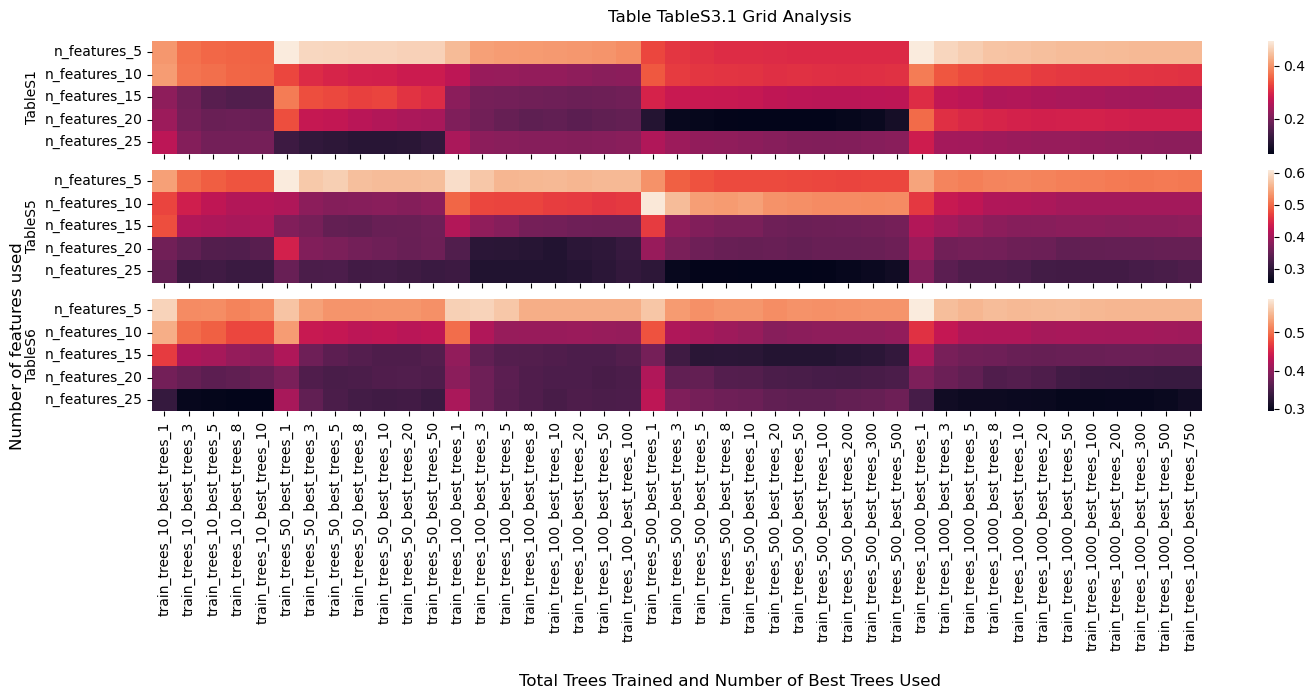

['TableS3.2_to_TableS1', 'TableS3.2_to_TableS5', 'TableS3.2_to_TableS6', 'TableS3.2_to_TableS13', 'TableS3.2_to_TableS14', 'TableS3.2_to_fon_children', 'TableS3.2_to_fon_ferrets', 'TableS3.2_to_hin_vu14vi15', 'TableS3.2_to_hin_vu15vi16', 'TableS3.2_to_hin_u15u16']


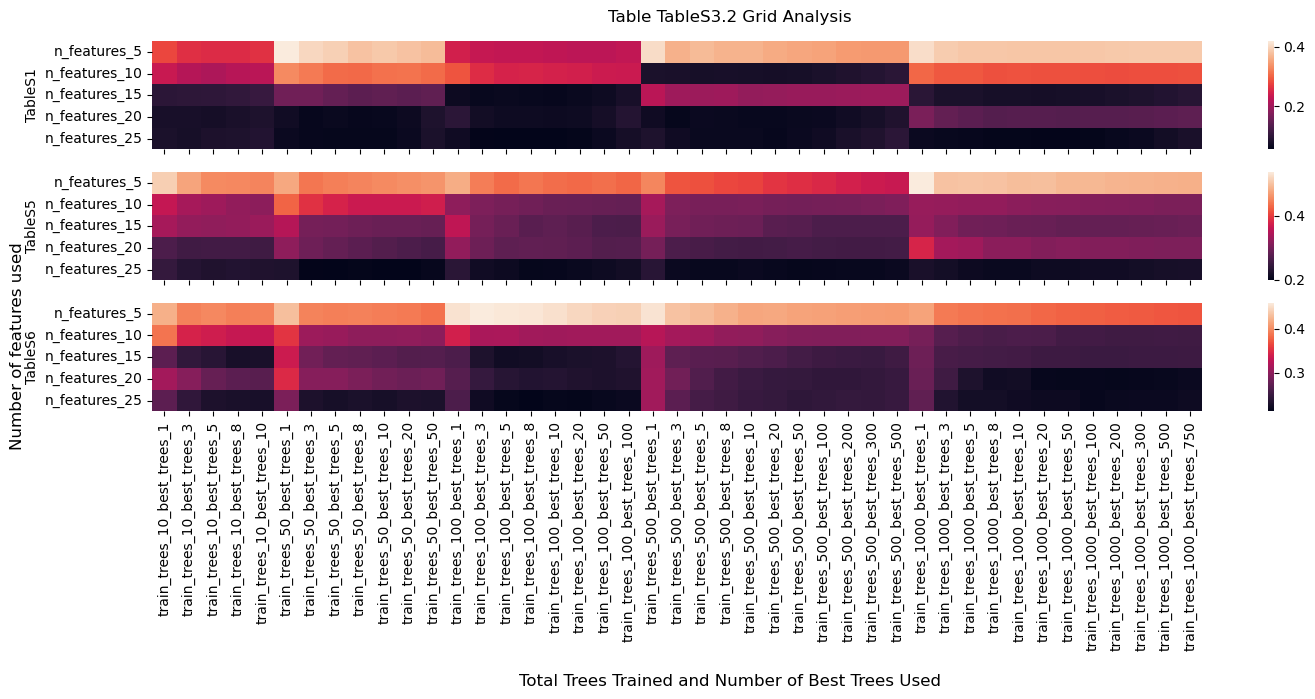

In [61]:
grid_heatmap_per_comparison, grid_search_df, n_features_info_df = grid_search_to_df(grid_search_path='grid_search_results.csv',
                                                                                    n_features_info_path='n_features_info.csv')
plot_grid_search(grid_heatmap_per_comparison, n_features_info_df, fs_x=15, fs_y=7, exclude_targets=['TableS13', 'TableS14', 'fon_children', 'fon_ferrets', 'hin_vu14vi15', 'hin_vu15vi16', 'hin_u15u16'])

## Secondary Grid Search: Adjusted n_feature values for tables with lower number of viable features to train on

['TableS3.1_to_TableS13', 'TableS3.1_to_TableS14', 'TableS3.1_to_fon_children', 'TableS3.1_to_fon_ferrets', 'TableS3.1_to_hin_vu14vi15', 'TableS3.1_to_hin_vu15vi16', 'TableS3.1_to_hin_u15u16']


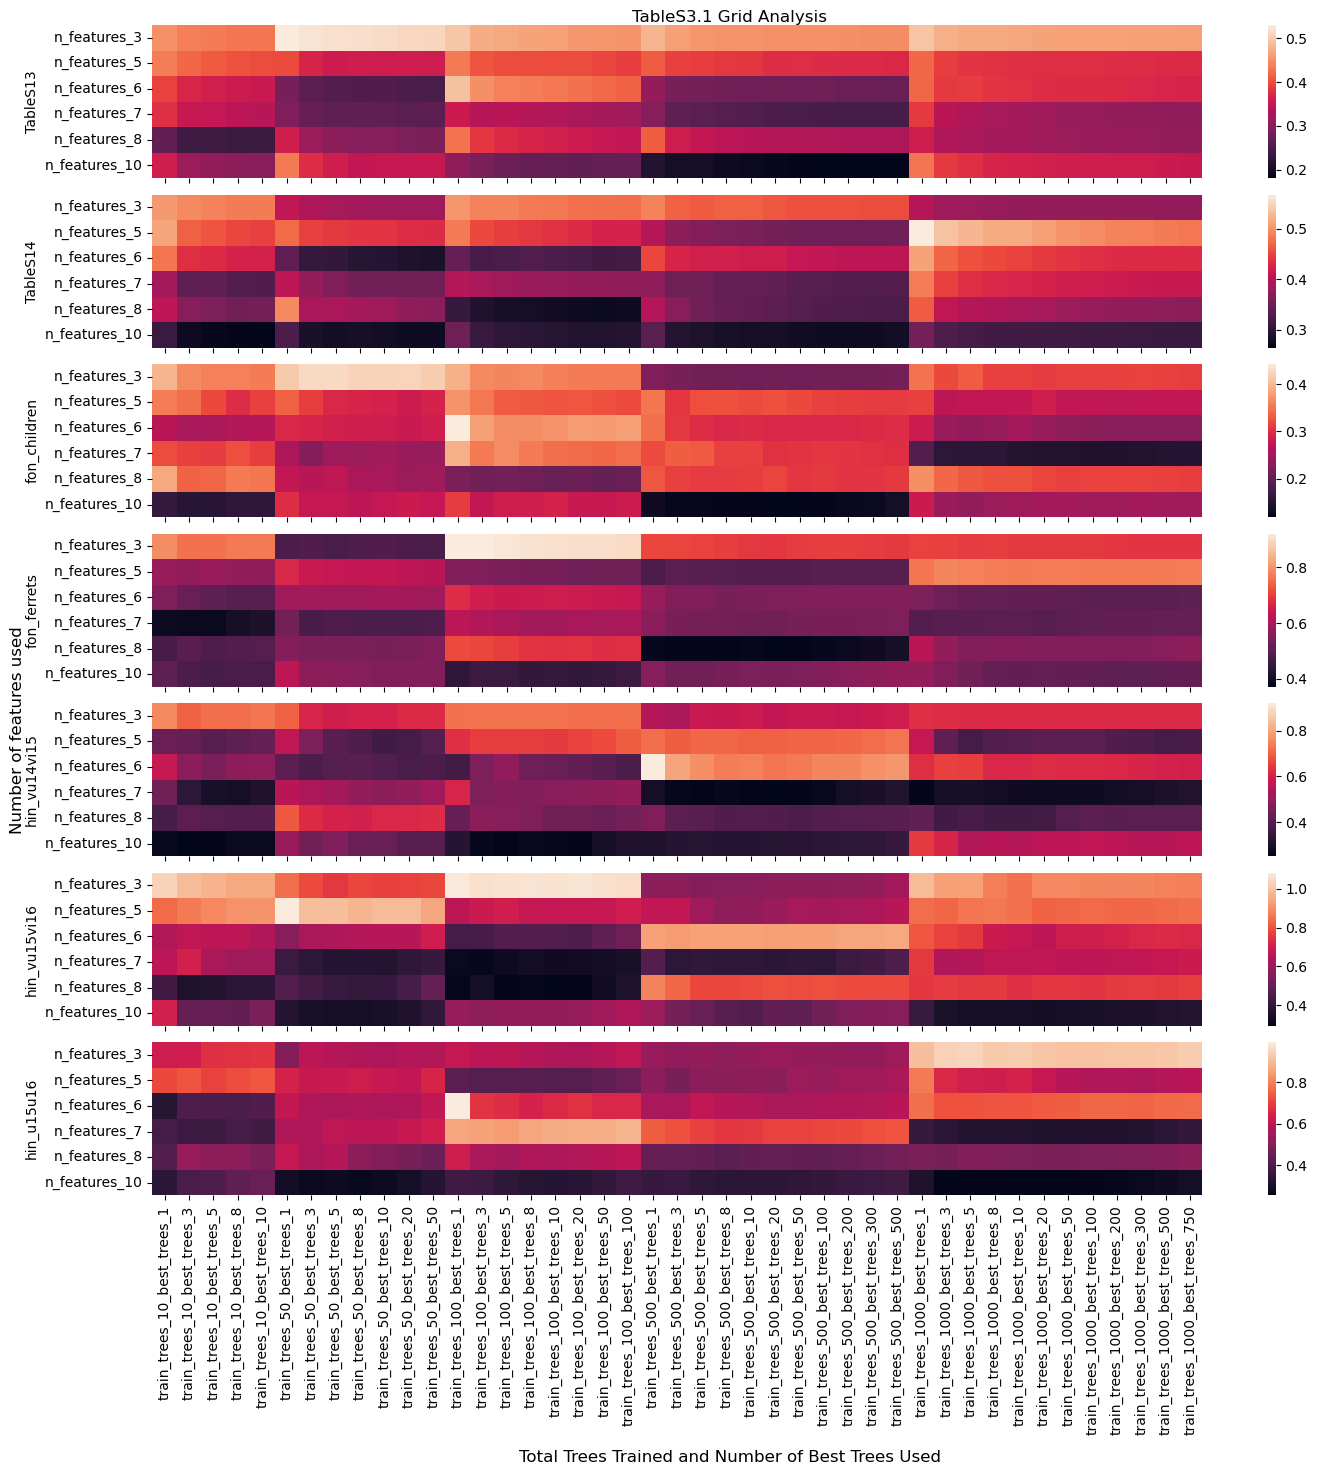

['TableS3.2_to_TableS13', 'TableS3.2_to_TableS14', 'TableS3.2_to_fon_children', 'TableS3.2_to_fon_ferrets', 'TableS3.2_to_hin_vu14vi15', 'TableS3.2_to_hin_vu15vi16', 'TableS3.2_to_hin_u15u16']


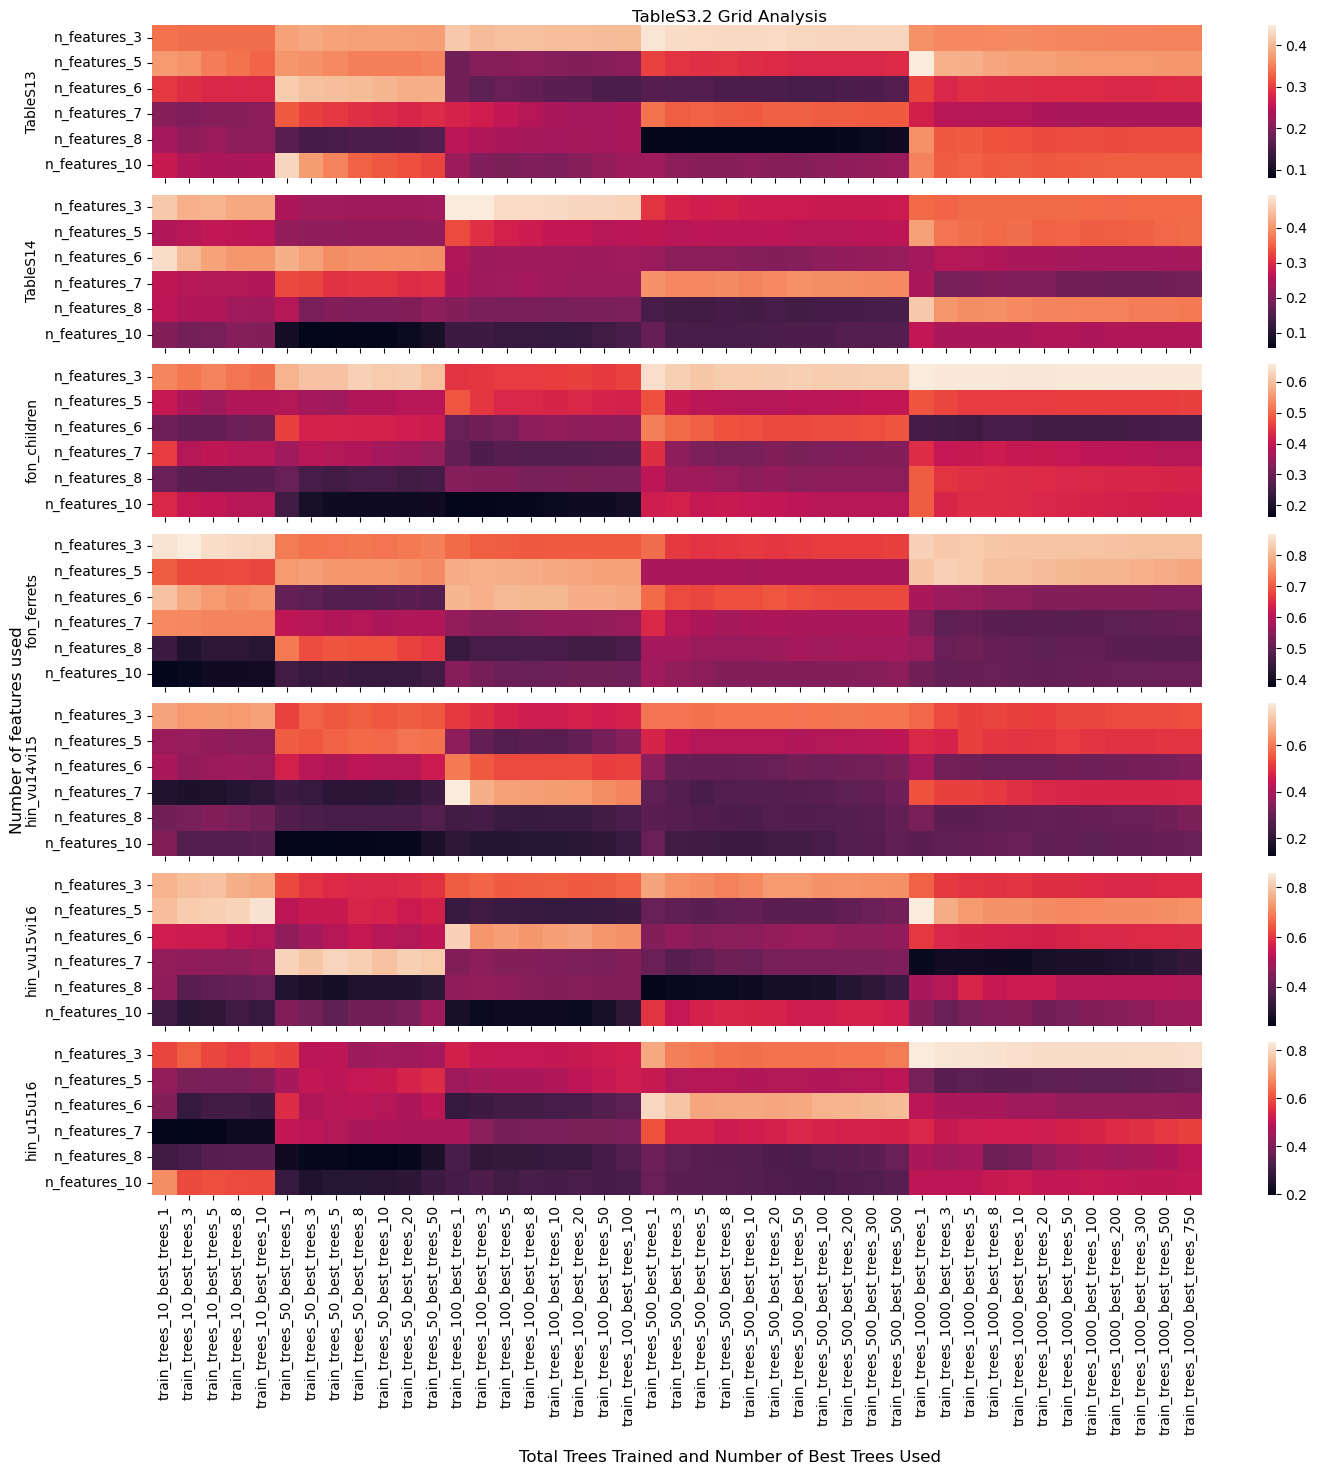

In [64]:
grid_heatmap_per_comparison, grid_search_df, n_features_info_df = grid_search_to_df(grid_search_path='grid_search_results_secondary.csv',
                                                                                    n_features_info_path='n_features_info_secondary.csv')
plot_grid_search(grid_heatmap_per_comparison, n_features_info_df, fs_x=15, fs_y=15, exclude_targets=[])

# Grid Search Analysis With and Without Replacement

## With Replacement

### High Overlap Grid Searches

['TableS3.1_to_TableS1', 'TableS3.1_to_TableS5', 'TableS3.1_to_TableS6']


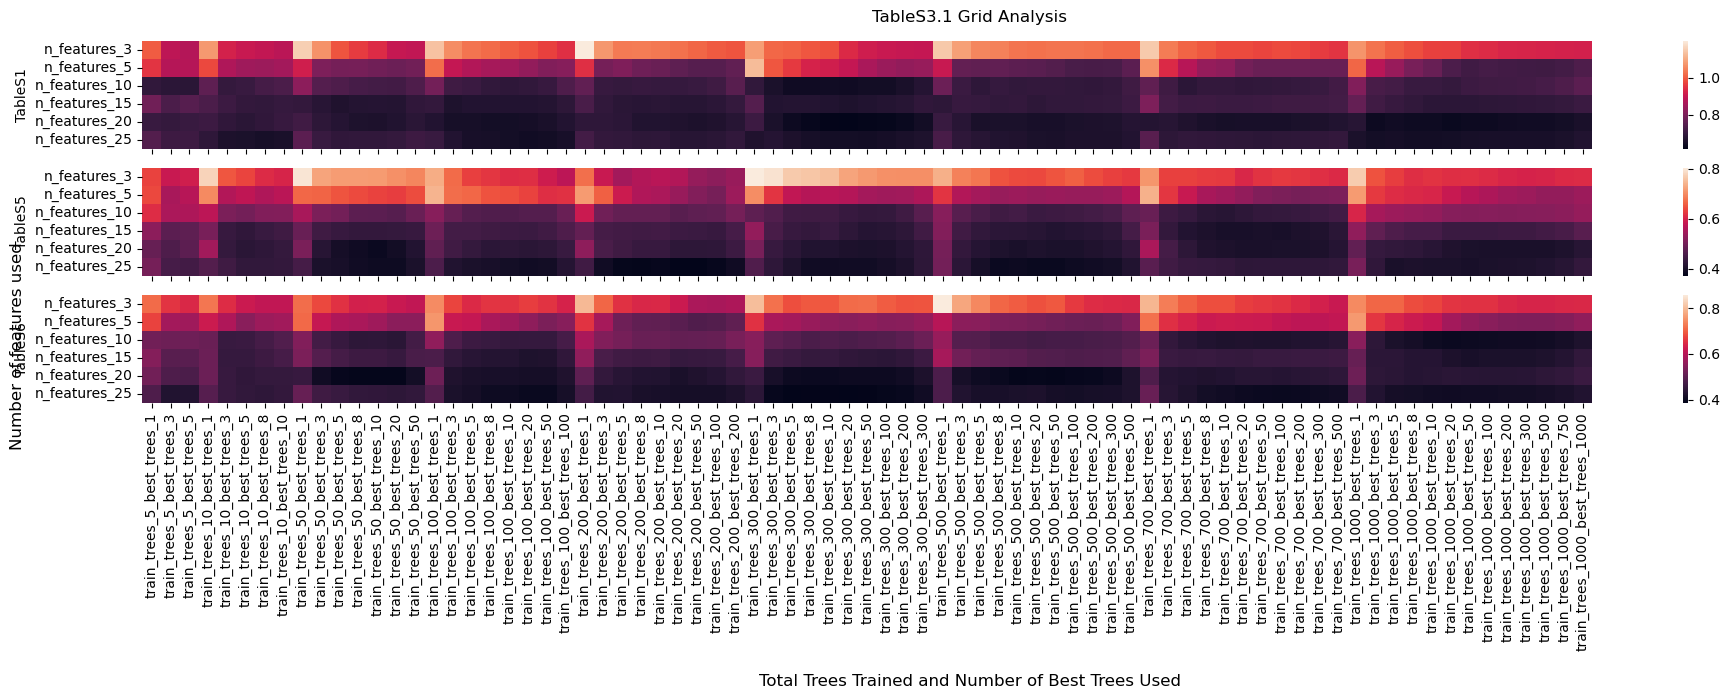

['TableS3.2_to_TableS1', 'TableS3.2_to_TableS5', 'TableS3.2_to_TableS6']


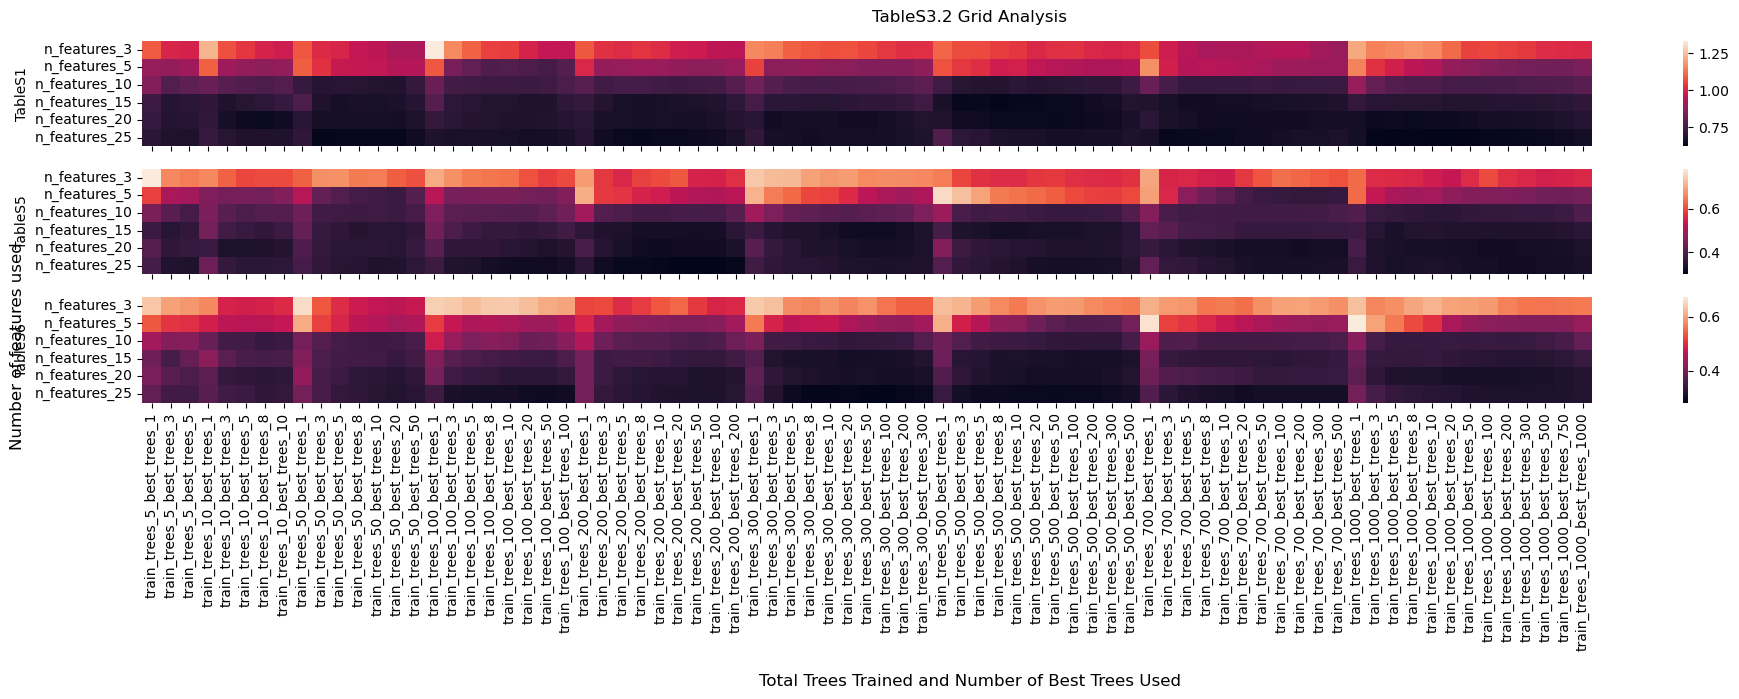

In [68]:
grid_heatmap_per_comparison, grid_search_df, n_features_info_df = grid_search_to_df(grid_search_path='grid_search_results_highoverlap_withreplacement.csv',
                                                                                    n_features_info_path='n_features_info_highoverlap_withreplacement.csv')
plot_grid_search(grid_heatmap_per_comparison, n_features_info_df, fs_x=20, fs_y=7, exclude_targets=[])

### Low Overlap Grid Searches

['TableS3.1_to_TableS13', 'TableS3.1_to_TableS14', 'TableS3.1_to_fon_children', 'TableS3.1_to_fon_ferrets', 'TableS3.1_to_hin_vu14vi15', 'TableS3.1_to_hin_vu15vi16', 'TableS3.1_to_hin_u15u16']


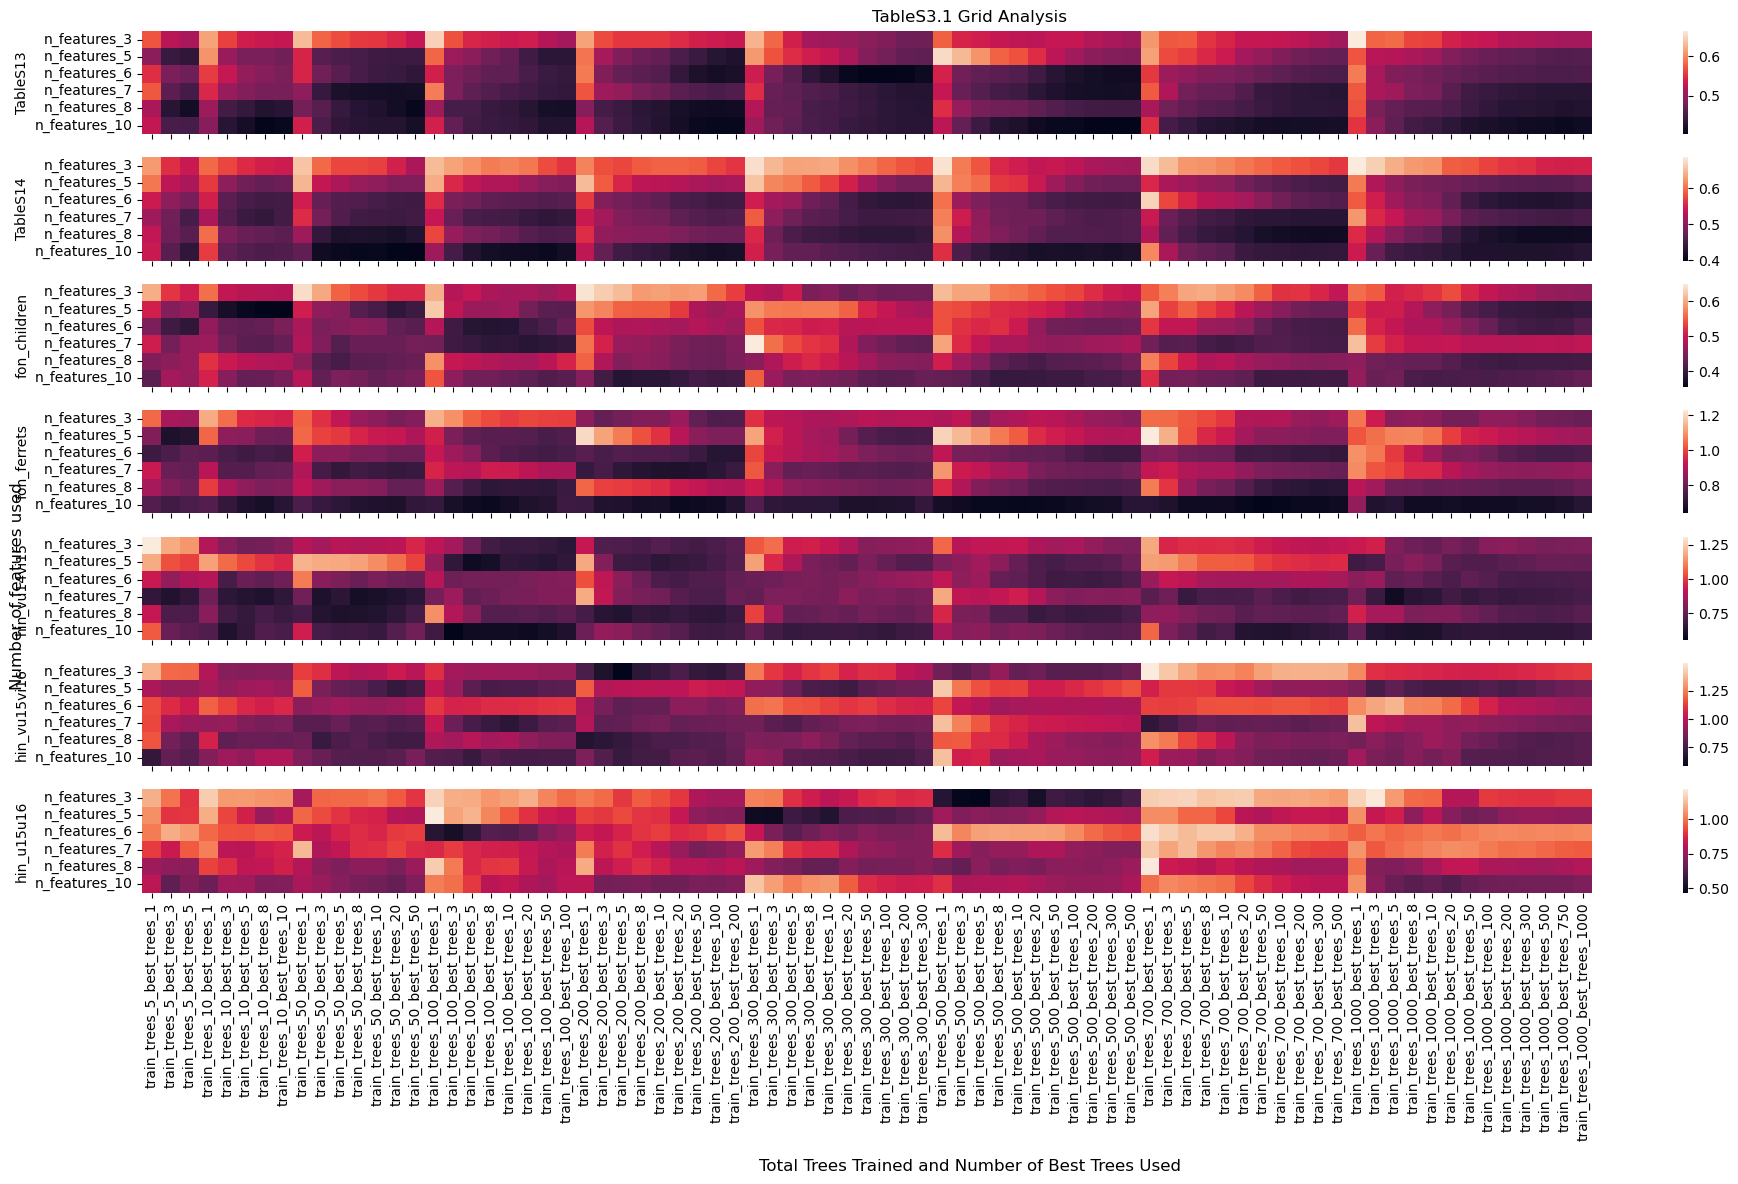

['TableS3.2_to_TableS13', 'TableS3.2_to_TableS14', 'TableS3.2_to_fon_children', 'TableS3.2_to_fon_ferrets', 'TableS3.2_to_hin_vu14vi15', 'TableS3.2_to_hin_vu15vi16', 'TableS3.2_to_hin_u15u16']


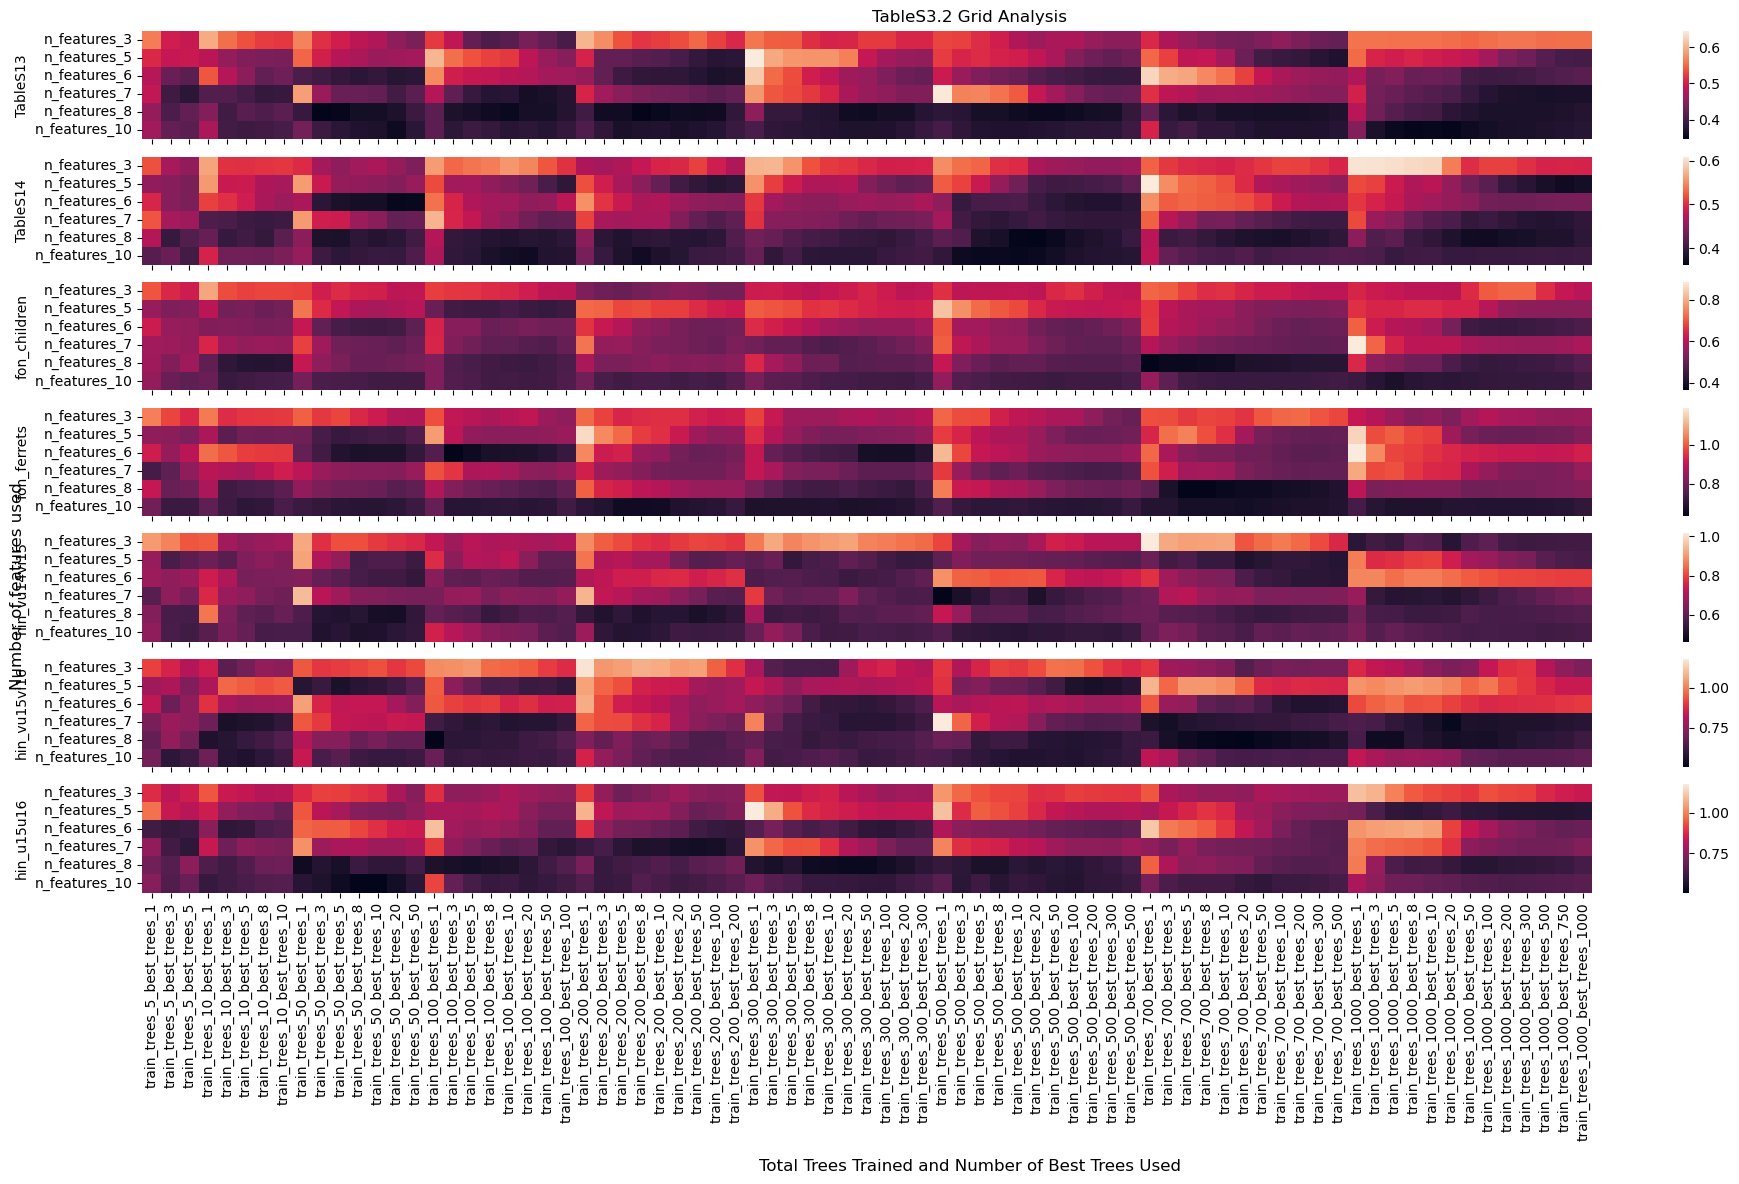

In [72]:
grid_heatmap_per_comparison, grid_search_df, n_features_info_df = grid_search_to_df(grid_search_path='grid_search_results_lowoverlap_withreplacement.csv',
                                                                                    n_features_info_path='n_features_info_lowoverlap_withreplacement.csv')
plot_grid_search(grid_heatmap_per_comparison, n_features_info_df, fs_x=20, fs_y=12, exclude_targets=[])

## Without Replacement

### High Overlap

['TableS3.1_to_TableS1', 'TableS3.1_to_TableS5', 'TableS3.1_to_TableS6']


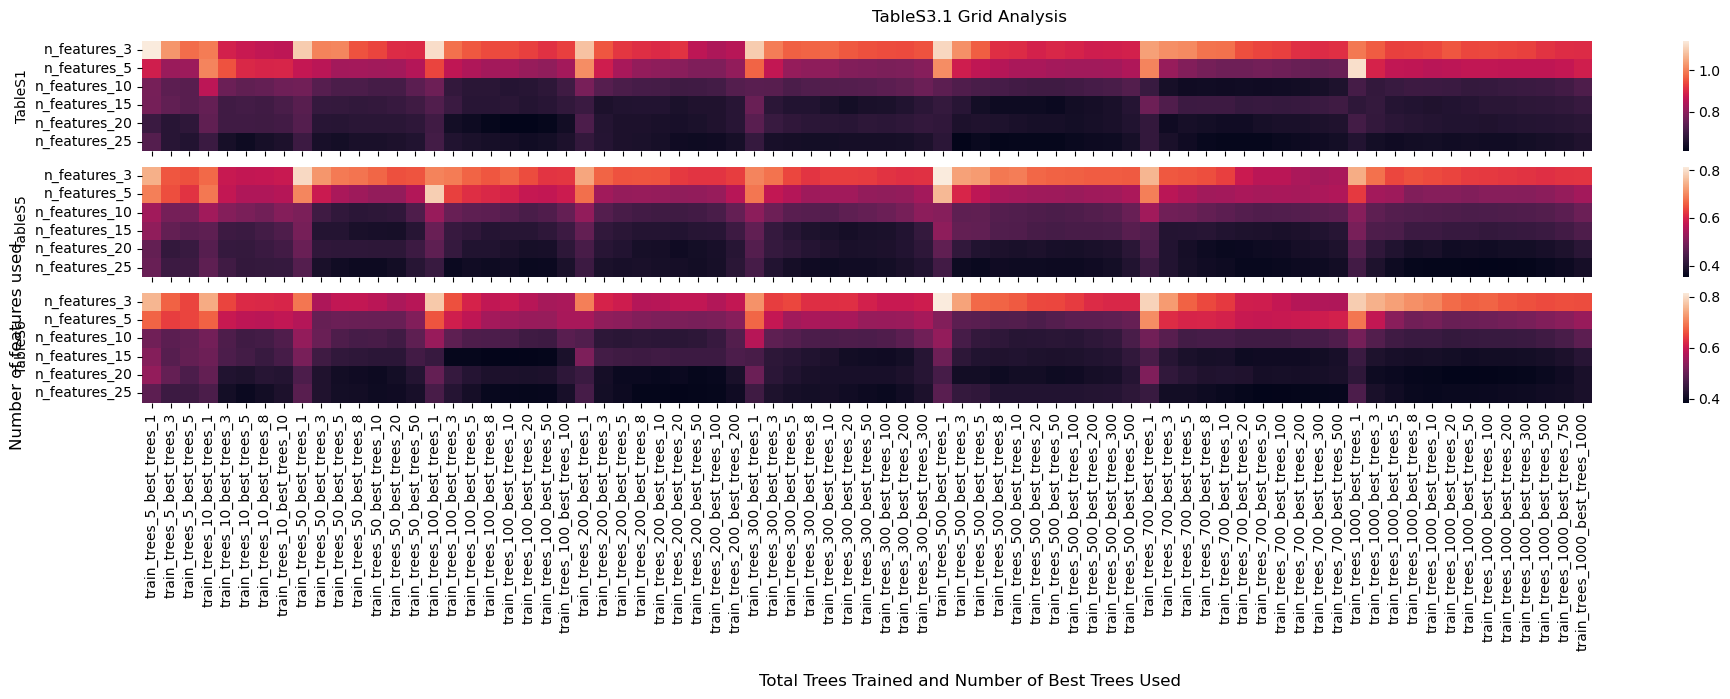

['TableS3.2_to_TableS1', 'TableS3.2_to_TableS5', 'TableS3.2_to_TableS6']


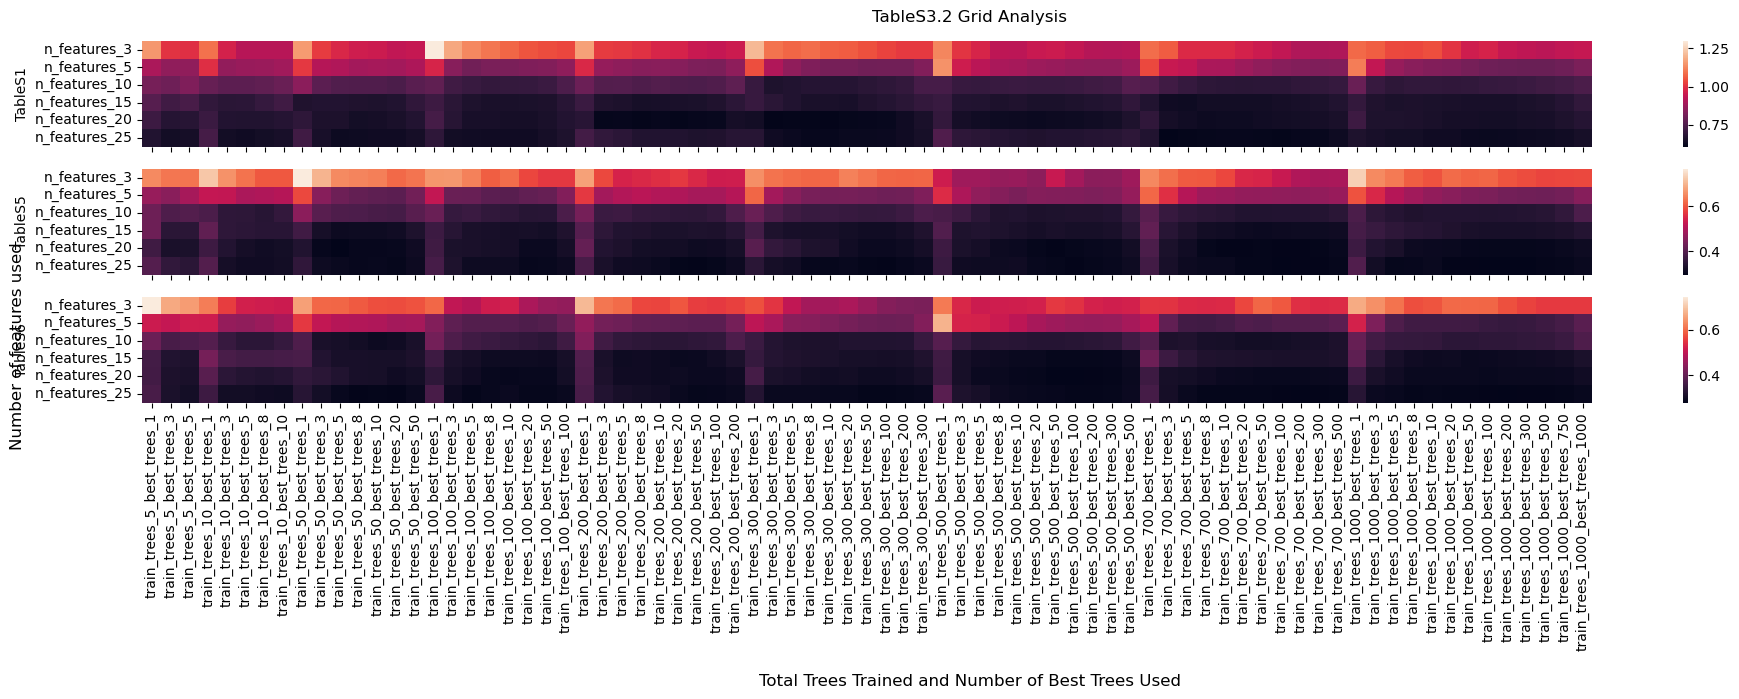

In [73]:
grid_heatmap_per_comparison, grid_search_df, n_features_info_df = grid_search_to_df(grid_search_path='grid_search_results_highoverlap_noreplacement.csv',
                                                                                    n_features_info_path='n_features_info_highoverlap_noreplacement.csv')
plot_grid_search(grid_heatmap_per_comparison, n_features_info_df, fs_x=20, fs_y=7, exclude_targets=[])

### Low Overlap

In [74]:
grid_heatmap_per_comparison, grid_search_df, n_features_info_df = grid_search_to_df(grid_search_path='grid_search_results_lowoverlap_noreplacement.csv',
                                                                                    n_features_info_path='n_features_info_lowoverlap_noreplacement.csv')
plot_grid_search(grid_heatmap_per_comparison, n_features_info_df, fs_x=20, fs_y=12, exclude_targets=[])

FileNotFoundError: [Errno 2] No such file or directory: 'grid_search_results_lowoverlap_noreplacement.csv'